This notebook is associated with the AMS JAMC manuscript titled: 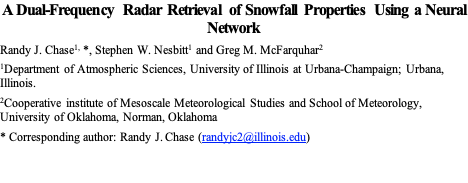

In [ ]:
#download needed packages 
!pip install netCDF4
!pip install colorcet
!pip install git+https://github.com/dopplerchase/DRpy.git

In [ ]:
import xarray as xr
from google.colab import drive
import os
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
import netCDF4
%pylab inline
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/DDA_Scattering/')
import colorcet as cc
import sklearn

#load unrimed database (training)
unrimed = xr.open_dataset('/content/gdrive/My Drive/Colab Notebooks/DDA_Scattering/Unrimed_simulation_wholespecturm_train_V2.nc',engine='netcdf4')
print(unrimed.IWC.shape)
#load unrimed database (testing)
unrimed_test = xr.open_dataset('/content/gdrive/My Drive/Colab Notebooks/DDA_Scattering/Unrimed_simulation_wholespecturm_test_V2.nc',engine='netcdf4')

In [ ]:
#make feature matrix 
X = np.zeros([unrimed['Z'].values.shape[0],3])
X[:,0] = unrimed['Z'].values #Ku 
X[:,1] = unrimed['Z'].values - unrimed['Z2'].values #DFR 
X[:,2] = unrimed['T_env'].values


#scale data (mean=0,std=1)
from sklearn.preprocessing import StandardScaler
import sklearn.model_selection
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y = np.hstack([np.log10(unrimed['Nw'].values).reshape([unrimed['IWC'].values.shape[0],1]),np.log10(unrimed['Dm'].values.reshape([unrimed['IWC'].values.shape[0],1])*1000),np.log10(unrimed['Dm_frozen'].values.reshape([unrimed['IWC'].values.shape[0],1])*1000)])

#normally we do not scale Y, but here I want to make sure it is not perfering one perceptron or another based on scale 
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train = X_scaled[:,:]
y_train  = y_scaled[:,:]


#make X test matrix
X_test = np.zeros([unrimed_test['Z'].values.shape[0],3])
X_test[:,0] = unrimed_test['Z'].values #Ku 
X_test[:,1] = unrimed_test['Z'].values - unrimed_test['Z2'].values #DFR
X_test[:,2] = unrimed_test['T_env'].values

#scale it 
X_test = scaler_X.transform(X_test)
y_test = np.hstack([np.log10(unrimed_test['Nw'].values).reshape([unrimed_test['IWC'].values.shape[0],1]),np.log10(unrimed_test['Dm'].values.reshape([unrimed_test['IWC'].values.shape[0],1])*1000),np.log10(unrimed_test['Dm_frozen'].values.reshape([unrimed_test['IWC'].values.shape[0],1])*1000)])
y_test = scaler_y.transform(y_test)

#save the scaling for operartional use
from pickle import dump 
dump(scaler_X, open('./scaler_X.pkl', 'wb'))
dump(scaler_y, open('./scaler_y.pkl', 'wb'))

## Load Tensorflow

In [ ]:
%load_ext tensorboard
# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow.keras import regularizers


In [ ]:
#set the seed so model weights all start in the sameish place 
tf.random.set_seed(42)

In [ ]:
def build_model(input_shape=3,output_shape=3,n_hidden_layers=2,layer_size=8,p=0.35,verbose=True,dropout=False,batch_norm=False,layer_norm=False):

  inner_list = []
  for i in np.arange(0,n_hidden_layers):
    if i == 0:
      inner_list.append(layers.Dense(layer_size, activation='relu', input_shape=[input_shape]))
    else:
      inner_list.append(layers.Dense(layer_size, activation='relu',))

    if batch_norm:
      inner_list.append(tf.keras.layers.BatchNormalization())
    elif layer_norm:
      inner_list.append(tf.keras.layers.LayerNormalization())

    if dropout:
      inner_list.append(tf.keras.layers.Dropout(p))

  inner_list.append(layers.Dense(output_shape,activation='linear'))
  model = keras.Sequential(inner_list)

  if verbose:
    print(model.summary())

  return model

def build_model_Sekelsky1999(input_shape=3):
  model = keras.Sequential([
    layers.Dense(7, activation='relu', input_shape=[input_shape]),
    layers.Dense(4, activation='relu', input_shape=[input_shape]),
    layers.Dense(2)])
  return model

def train_model(epochs = 250,lr = 0.001,input_shape=3,output_shape=3,n_hidden_layers=2,loss='mse',optim='RMSprop',layer_size=8,early_stop=True,batch_size=512,dropout=False,p=0.35,layer_norm=False,batch_norm=False):
  
  model = build_model(input_shape=input_shape,output_shape=output_shape,n_hidden_layers=n_hidden_layers,layer_size=layer_size,dropout=dropout,batch_norm=batch_norm,layer_norm=layer_norm,p=p)

  if optim=='RMSprop':
    optimizer = tf.keras.optimizers.RMSprop(lr)
  else:
    optimizer = tf.keras.optimizers.Adam(lr)

  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=['mae'])
  
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.log')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

  callback = []
  callback.append(tensorboard_callback)
  callback.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,min_lr=1e-15))

  if early_stop: 
    callback.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50))

  device_name = tf.test.gpu_device_name()
  if device_name == '/device:GPU:0':
    with tf.device('/device:GPU:0'):
        print("Using GPU")
        model.fit(x=X_train[:,0:input_shape], 
                  y=y_train, 
                  epochs=epochs, 
                  validation_data=(X_test[:,0:input_shape], y_test), 
                  callbacks=[callback],batch_size=batch_size)
  else:
      print("Using CPU")
      model.fit(x=X_train[:,0:input_shape], 
                y=y_train, 
                epochs=epochs, 
                validation_data=(X_test[:,0:input_shape], y_test), 
                callbacks=[callback],batch_size=batch_size)
      
  model.n_hidden_layers = n_hidden_layers
  return model 

In [ ]:
#train model
model = train_model(epochs=250,lr=0.001,batch_norm=True,n_hidden_layers=6,layer_size=8,dropout=False)